In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from scipy import interp
from IPython.display import Image
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Custom Python Files
from dataprep.dataPrep import cleanData
from dataprep.modelPrep import model_prep
from dataprep.modelPrep import plotROCCurve

%matplotlib inline 

### Load in data for modeling

In [2]:
xcols = ['admins', 'employees','contractdays', 'usecompetitors','callcycle_numeric', 'associateddeals','timescontacted','sessions', 'FF', 'strategic']

# xcols = ["admins","employees","usecompetitors","contractdays",
#          "callcycle", "timescontacted", "daysAsCustomer",
#          "sessions", "FF","assoccontacts","associatedpredictionlead",
#          "publiclytraded","strategic", "MRR"]
#xcols = ['usecompetitors', 'callcycle','sessions', 'FF', 'strategic']
# xcols = "ALL"

ycol = "churn"

df = cleanData("PSCCustomerData.csv")

X, y, xcolnames = model_prep(df,xcols,ycol)

In [3]:
xcols_lr = ['usecompetitors', 'callcycle','sessions', 'FF', 'strategic']

ycol_lr = "churn"

X_lr, y_lr, xcolnames_lr = model_prep(df,xcols,ycol)

### Stratified Cross Validation - Since the Response values are not balanced

In [6]:
def stratified_cv(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X,y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

def stratified_cv_smote(X, y, clf_class, shuffle=True, n_folds=10, **kwargs):
    stratified_k_fold = StratifiedKFold(n_splits=n_folds, shuffle=shuffle)
    y_pred = y.copy()
    # ii -> train
    # jj -> test indices
    for ii, jj in stratified_k_fold.split(X,y): 
        X_train, X_test = X[ii], X[jj]
        y_train = y[ii]

        # Use SMOTE to boost training set
        sm = SMOTE(random_state = 33)
        X_train_new, y_train_new = sm.fit_sample(X_train, y_train.ravel())

        clf = clf_class(**kwargs)
        clf.fit(X_train_new,y_train_new)
        y_pred[jj] = clf.predict(X_test)
    return y_pred

In [7]:
import warnings
warnings.filterwarnings('ignore')

print('Gradient Boosting Classifier:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Gradient Boosting Classifier SMOTE:  {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, svm.SVC))))
print('Support vector machine(SVM) SMOTE:   {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, svm.SVC))))
print('Random Forest Classifier:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('Random Forest Classifier SMOTE:      {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('K Nearest Neighbor Classifier SMOTE: {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Logistic Regression SMOTE:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, linear_model.LogisticRegression))))
print('XGBoost:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv(X, y, XGBClassifier))))
print('XGBoost SMOTE:           {:.2f}'.format(metrics.accuracy_score(y, stratified_cv_smote(X, y, XGBClassifier))))

Gradient Boosting Classifier:  0.83
Gradient Boosting Classifier SMOTE:  0.81
Support vector machine(SVM):   0.80
Support vector machine(SVM) SMOTE:   0.69
Random Forest Classifier:      0.84
Random Forest Classifier SMOTE:      0.82
K Nearest Neighbor Classifier: 0.78
K Nearest Neighbor Classifier SMOTE: 0.71
Logistic Regression:           0.80
Logistic Regression SMOTE:           0.69
XGBoost:           0.86
XGBoost SMOTE:           0.82


### Confusion Matrices

In [ ]:
grad_ens_conf_matrix      = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))
sns.heatmap(grad_ens_conf_matrix, annot=True,  fmt='');
title = 'Gradient Boosting'
plt.title(title);

In [ ]:
svm_svc_conf_matrix       = metrics.confusion_matrix(y, stratified_cv(X, y, svm.SVC))
sns.heatmap(svm_svc_conf_matrix, annot=True,  fmt='');
title = 'SVM'
plt.title(title);

In [ ]:
random_forest_conf_matrix = metrics.confusion_matrix(y, stratified_cv(X, y, ensemble.RandomForestClassifier))
sns.heatmap(random_forest_conf_matrix, annot=True,  fmt='');
title = 'Random Forest'
plt.title(title);

In [ ]:
k_neighbors_conf_matrix   = metrics.confusion_matrix(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))
sns.heatmap(k_neighbors_conf_matrix, annot=True,  fmt='');
title = 'KNN'
plt.title(title);

In [ ]:
logistic_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, linear_model.LogisticRegression))
sns.heatmap(logistic_reg_conf_matrix, annot=True,  fmt='');
title = 'Logistic Regression'
plt.title(title);

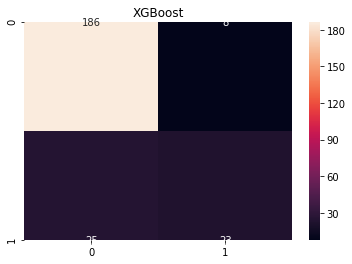

In [10]:
xgboost_reg_conf_matrix  = metrics.confusion_matrix(y, stratified_cv(X, y, XGBClassifier))
sns.heatmap(xgboost_reg_conf_matrix, annot=True,  fmt='');
title = 'XGBoost'
plt.title(title);

### Classification Reports

In [10]:
print('Gradient Boosting Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.GradientBoostingClassifier))))
print('Gradient Boosting Classifier SMOTE:\n {}\n'.format(metrics.classification_report(y, stratified_cv_smote(X, y, ensemble.GradientBoostingClassifier))))
print('Support vector machine(SVM):\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, svm.SVC))))
print('Support vector machine(SVM) SMOTE:\n {}\n'.format(metrics.classification_report(y, stratified_cv_smote(X, y, svm.SVC))))
print('Random Forest Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, ensemble.RandomForestClassifier))))
print('Random Forest Classifier SMOTE:\n {}\n'.format(metrics.classification_report(y, stratified_cv_smote(X, y, ensemble.RandomForestClassifier))))
print('K Nearest Neighbor Classifier:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, neighbors.KNeighborsClassifier))))
print('K Nearest Neighbor Classifier SMOTE:\n {}\n'.format(metrics.classification_report(y, stratified_cv_smote(X, y, neighbors.KNeighborsClassifier))))
print('Logistic Regression:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, linear_model.LogisticRegression))))
print('Logistic Regression SMOTE:\n {}\n'.format(metrics.classification_report(y, stratified_cv_smote(X, y, linear_model.LogisticRegression))))

Gradient Boosting Classifier:
               precision    recall  f1-score   support

           0       0.90      0.93      0.91       194
           1       0.67      0.58      0.62        48

    accuracy                           0.86       242
   macro avg       0.78      0.76      0.77       242
weighted avg       0.85      0.86      0.86       242


Gradient Boosting Classifier SMOTE:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       194
           1       0.64      0.60      0.62        48

    accuracy                           0.86       242
   macro avg       0.77      0.76      0.77       242
weighted avg       0.85      0.86      0.85       242


Support vector machine(SVM):
               precision    recall  f1-score   support

           0       0.91      0.94      0.92       194
           1       0.72      0.60      0.66        48

    accuracy                           0.88       242
   macro avg       0.82     

In [11]:
print('XGBoost:\n {}\n'.format(metrics.classification_report(y, stratified_cv(X, y, XGBClassifier))))

XGBoost:
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       194
           1       0.71      0.56      0.63        48

    accuracy                           0.87       242
   macro avg       0.80      0.75      0.77       242
weighted avg       0.86      0.87      0.86       242




### AUC Curves

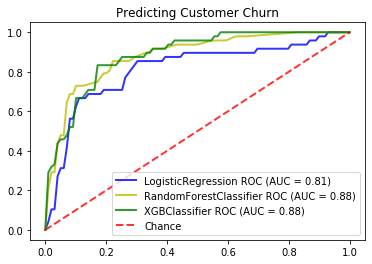

In [15]:
seed = 1234

# Plotting Setup
fig, ax = plt.subplots()

# plotROCCurve(clf_class, X, y, axis, random_state, **kwargs)

# LR ROC Curve Plotting
lr = linear_model.LogisticRegression
plotROCCurve(lr, X=X_lr,y=y_lr,axis=ax,color='b',random_state=seed,C=10, class_weight='balanced', solver='liblinear')

# Random Forest ROC Curve Plotting
rf = ensemble.RandomForestClassifier
plotROCCurve(rf, X,y,ax,'y',seed)

# XGBoost ROC Curve Plotting
xgb = XGBClassifier
plotROCCurve(xgb, X,y,ax,'g',seed)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()

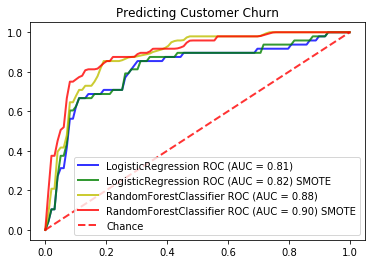

In [14]:
seed = 1234

# Plotting Setup
fig, ax = plt.subplots()

# plotROCCurve(clf_class, X, y, axis, random_state, **kwargs)

# LR ROC Curve Plotting
lr = linear_model.LogisticRegression
plotROCCurve(lr, X=X,y=y,axis=ax,color='b',random_state=seed,C=10, class_weight='balanced', solver='liblinear')

# LR ROC Curve Plotting SMOTE
lr = linear_model.LogisticRegression
plotROCCurve_smote(lr, X=X,y=y,axis=ax,color='g',random_state=seed,C=10, class_weight='balanced', solver='liblinear')

# Random Forest ROC Curve Plotting
rf = ensemble.RandomForestClassifier
plotROCCurve(rf, X,y,ax,'y',seed)

# Random Forest ROC Curve Plotting SMOTE
rf = ensemble.RandomForestClassifier
plotROCCurve_smote(rf, X,y,ax,'r',seed)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Predicting Customer Churn")
ax.legend(loc="lower right")
plt.show()

### Final Model Selection